In [1]:
import time
import cv2
import datetime
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import fashion_mnist
from scipy.spatial.distance import cdist
from skimage.feature import hog, local_binary_pattern
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, WhiteKernel

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [3]:
label = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
def showimage(image, train):
    if train == True:
        plt.imshow(x_train[image], cmap = 'gray')
        plt.axis('off')
        plt.show()
        return (label[y_train[image]])
    else:
        plt.imshow(x_test[image], cmap = 'gray')
        plt.axis('off')
        plt.show()
        return (label[y_test[image]])

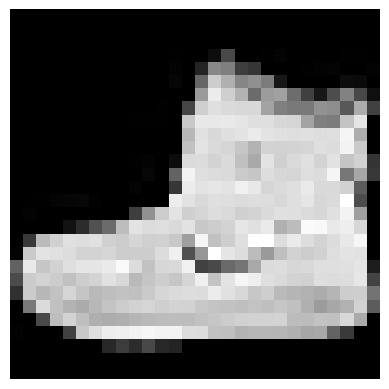

'Ankle boot'

In [5]:
showimage(0,1)

# Flatten

In [6]:
def flatten(train, test):
    
    return train.reshape(train.shape[0], -1), test.reshape(test.shape[0], -1)

# PCA

In [7]:
def pca(train, test, variance):
    
    train_flatten, test_flatten = flatten(train, test)
    
    pca = PCA(n_components = variance)
    pca.fit(train_flatten)
    
    return pca.transform(train_flatten), pca.transform(test_flatten)

# SIFT

In [8]:
def sift(train, test, num_cluster):
    
    sift = cv2.SIFT_create()
    
    sift_descriptors_train = []
    for image in train:
        kp, des = sift.detectAndCompute(image, None)
        sift_descriptors_train.append(des)
        
    sift_descriptors_test = []
    for image in test:
        kp, des = sift.detectAndCompute(image, None)
        sift_descriptors_test.append(des)
        
    sift_all_descriptors = []
    for descriptor in sift_descriptors_train:
        if descriptor is not None:
            for des in descriptor:
                sift_all_descriptors.append(des)
                
    sift_bow_dict = []
    kmeans = KMeans(n_clusters = num_cluster)
    kmeans.fit(sift_all_descriptors)
    sift_bow_dict = kmeans.cluster_centers_
    
    train_sift = []
    for image in sift_descriptors_train:
        features = np.array([0] * num_cluster)
        if image is not None:
            distance = cdist(image, sift_bow_dict)
            argmin = np.argmin(distance, axis = 1)
            for i in argmin:
                features[i] += 1
        train_sift.append(features)

    test_sift = []
    for image in sift_descriptors_test:
        features = np.array([0] * num_cluster)
        if image is not None:
            distance = cdist(image, sift_bow_dict)
            argmin = np.argmin(distance, axis = 1)
            for i in argmin:
                features[i] += 1
        test_sift.append(features)
        
    return np.array(train_sift), np.array(test_sift)

# HOG

In [9]:
def c_hog(train, test, orientations, ppc, cpb):
    
    train_hog = []
    test_hog = []

    for image in train:
        fd, hog_image = hog(image, orientations=orientations, pixels_per_cell=(ppc,ppc), cells_per_block=(cpb, cpb), visualize=True)
        train_hog.append(fd)

    for image in test:
        fd, hog_image = hog(image, orientations=orientations, pixels_per_cell=(ppc,ppc), cells_per_block=(cpb, cpb), visualize=True)
        test_hog.append(fd)
        
    return np.array(train_hog), np.array(test_hog)

# LBP

In [10]:
def lbp(train, test, radius, flat):

    train_lbp = []
    test_lbp = []

    for image in train:
        lbp = local_binary_pattern(image, 8 * radius, radius, 'uniform')
        train_lbp.append(lbp)

    for image in test:
        lbp = local_binary_pattern(image, 8 * radius, radius, 'uniform')
        test_lbp.append(lbp)
        
    train_lbp = np.array(train_lbp)
    test_lbp = np.array(test_lbp)
        
    if flat == True:
        return flatten(train_lbp.round().astype(np.uint8), test_lbp.round().astype(np.uint8))
    else:
        return train_lbp.round().astype(np.uint8), test_lbp.round().astype(np.uint8)

# SIFT + LBP

In [11]:
def siftlbp(train, test, num_cluster, radius):
    
    train_siftlbp, test_siftlbp = lbp(train, test, radius, 0)
    
    return sift(train_siftlbp, test_siftlbp, num_cluster)

# HOG + LBP

In [12]:
def hoglbp(train, test, orientations, ppc, cpb, radius):
    
    train_hoglbp, test_hoglbp = lbp(train, test, radius, 0)
    
    return c_hog(train_hoglbp, test_hoglbp, orientations, ppc, cpb)

# Optimize

### PCA

In [ ]:
var = [0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
for i in var:
    for j in range(0,5):
        start = time.time()
        train_x, valid_x = pca(x_train[j*12000:j*12000+2000], x_train[j*12000+2000:(j+1)*12000], i)
        
        train_y = y_train[j*12000:j*12000+2000]
        valid_y = y_train[j*12000+2000:(j+1)*12000]

        kernel = RationalQuadratic()
        gpc = GaussianProcessClassifier(kernel=kernel)
        gpc.fit(train_x, train_y)

        pred_y = gpc.predict(valid_x)
        end = time.time()
        print(datetime.timedelta(seconds = int(end-start)))
        print([i, j+1])
        print(accuracy_score(valid_y, pred_y))

In [ ]:
# 0.5 [0.6244,0.62,0.6399,0.6386,0.6204]
# 0.6 [0.7028,0.6937,0.7103,0.711,0.6951]
# 0.7 [0.7337,0.7455,0.7388,0.741,0.739]
# 0.8 [0.7857,0.7771,0.7804,0.7818,0.7709]
# 0.9 [0.7709,0.7901,0.7936,0.7903,0.7815]
# 0.99 [0.7938,0.7889,0.791,0.7906,0.7781]

### SIFT

In [ ]:
sift = cv2.SIFT_create()

sift_descriptors_train = []
for image in x_train:
    kp, des = sift.detectAndCompute(image, None)
    sift_descriptors_train.append(des)

sift_all_descriptors = []
for descriptor in sift_descriptors_train:
    if descriptor is not None:
        for des in descriptor:
            sift_all_descriptors.append(des)

In [ ]:
num = [i for i in range(10,201,10)]
for num_cluster in num:
    
    start = time.time()
    sift_bow_dict = []
    kmeans = KMeans(n_clusters = num_cluster)
    kmeans.fit(sift_all_descriptors)
    sift_bow_dict = kmeans.cluster_centers_

    train_sift = []
    for image in sift_descriptors_train:
        features = np.array([0] * num_cluster)
        if image is not None:
            distance = cdist(image, sift_bow_dict)
            argmin = np.argmin(distance, axis = 1)
            for i in argmin:
                features[i] += 1
        train_sift.append(features)
    
    for j in range(0,5):
    
        train_x = train_sift[j*12000:j*12000+2000]
        valid_x = train_sift[j*12000+2000:(j+1)*12000]
        train_y = y_train[j*12000:j*12000+2000]
        valid_y = y_train[j*12000+2000:(j+1)*12000]

        kernel = RationalQuadratic()
        gpc = GaussianProcessClassifier(kernel=kernel)
        gpc.fit(train_x, train_y)

        pred_y = gpc.predict(valid_x)
        end = time.time()
        print(datetime.timedelta(seconds = int(end-start)))
        print([num_cluster, j+1])
        print(accuracy_score(valid_y, pred_y))

In [ ]:
# 10 [0.356,0.352,0.3572,0.3563,0.356]
# 20 [0.4336,0.4319,0.4389,0.4382,0.421]
# 30 [0.4692,0.4692,0.4661,0.4789,0.4547]
# 40 [0.4896,0.48,0.4791,0.4827,0.4702]
# 50 [0.4928,0.4922,0.495,0.5024,0.4895]
# 60 [0.5052,0.4921,0.5013,0.5009,0.4898]
# 70 [0.5149,0.5193,0.5144,0.5139,0.5108]
# 80 [0.5232,0.5188,0.5174,0.5205,0.5154]
# 90 [0.5307,0.5309,0.5276,0.5352,0.5232]
# 100 [0.5385,0.5364,0.534,0.5376,0.528]
# 110 [0.5386,0.538,0.5363,0.5478,0.5332]
# 120 [0.5442,0.5437,0.5402,0.549,0.5333]
# 130 [0.5445,0.5462,0.536,0.5482,0.5334]
# 140 [0.5503,0.5543,0.5485,0.559,0.5385]
# 150 [0.5503,0.553,0.5497,0.5551,0.5442]
# 160 [0.5515,0.5545,0.529,0.5634,0.5469]
# 170 [0.5535,0.5545,0.5302,0.5629,0.5426]
# 180 [0.5499,0.5543,0.5351,0.5623,0.5447]
# 190 [0.552,0.5585,0.559,0.565,0.5534]
# 200 [0.5505,0.5597,0.5308,0.5578,0.5455]

### HOG

In [ ]:
ori = [8, 9]
ppc = [4, 8]
cpb = [1, 2, 3]
for i in ori:
    for j in ppc:
        for k in cpb:
            for l in range(0,5):
                
                start = time.time()
                train_x, valid_x = c_hog(x_train[l*12000:l*12000+2000], x_train[l*12000+2000:(l+1)*12000], i, j, k)

                train_y = y_train[l*12000:l*12000+2000]
                valid_y = y_train[l*12000+2000:(l+1)*12000]

                kernel = RationalQuadratic()
                gpc = GaussianProcessClassifier(kernel=kernel)
                gpc.fit(train_x, train_y)

                pred_y = gpc.predict(valid_x)
                end = time.time()
                print(datetime.timedelta(seconds = int(end-start)))
                print([i, j, k, l+1])
                print(accuracy_score(valid_y, pred_y))

In [ ]:
# 841 [0.8028,0.8002,0.8081,0.8116,0.7905]
# 842 [0.8222,0.8206,0.825,0.8309,0.8196]
# 843 [0.8256,0.8217,0.8231,0.8307,0.8203]
# 881 [0.7437,0.7447,0.7432,0.7466,0.7401]
# 882 [0.7794,0.7739,0.7712,0.7742,0.7667]
# 883 [0.7872,0.7817,0.7857,0.7896,0.778]
# 941 [0.801,0.7972,0.8124,0.8148,0.7941]
# 942 [0.827,0.8193,0.8275,0.8298,0.802]
# 943 [0.8273,0.8219,0.8248,0.8286,0.8197]
# 981 [0.7467,0.7463,0.7495,0.7488,0.7435]
# 982 [0.7852,0.777,0.777,0.7767,0.7759]
# 983 [0.7898,0.7853,0.7881,0.7907,0.7822]

### LBP

In [14]:
rad = [i for i in range(8,11)]
for i in rad:
    for j in range(0,5):
        
        start = time.time()
        train_x, valid_x = lbp(x_train[j*12000:j*12000+2000], x_train[j*12000+2000:(j+1)*12000], i, 1)
        
        train_y = y_train[j*12000:j*12000+2000]
        valid_y = y_train[j*12000+2000:(j+1)*12000]

        kernel = RationalQuadratic()
        gpc = GaussianProcessClassifier(kernel=kernel)
        gpc.fit(train_x, train_y)

        pred_y = gpc.predict(valid_x)
        end = time.time()
        print(datetime.timedelta(seconds = int(end-start)))
        print([i, j+1])
        print(accuracy_score(valid_y, pred_y))

C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpc.py:472: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0:19:36
[8, 1]
0.7204


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:25:48
[8, 2]
0.7205


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:25:57
[8, 3]
0.7198


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:29:49
[8, 4]
0.7237


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:23:46
[8, 5]
0.717


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:22:50
[9, 1]
0.7106


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:24:11
[9, 2]
0.7143


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:22:34
[9, 3]
0.7095


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:23:27
[9, 4]
0.718


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:23:05
[9, 5]
0.7015


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:22:08
[10, 1]
0.7043


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:20:59
[10, 2]
0.7093


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:22:06
[10, 3]
0.7082


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:21:08
[10, 4]
0.7145


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:19:18
[10, 5]
0.7005


In [ ]:
# 1 [0.7008,0.7007,0.7098,0.7236,0.7039]
# 2 [0.7292,0.7227,0.7319,0.7432,0.7196]
# 3 [0.7435,0.7354,0.6986,0.7523,0.7227]
# 4 [0.7485,0.741,0.7483,0.7607,0.7395]
# 5 [0.7447,0.7367,0.7405,0.7497,0.7305]
# 6 [0.7345,0.69,0.7384,0.7507,0.7319]
# 7 [0.7202,0.7262,0.7303,0.7332,0.7217]
# 8 [0.7204,0.7205,0.7198,0.7237,0.717]
# 9 [0.7106,0.7143,0.7095,0.718,0.7015]
# 10 [0.7043,0.7093,0.7082,0.7145,0.7005]